In [3]:
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()



In [4]:

def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    attention_w = k / k.sum(0)  # Normalization over keys for each query
    y_hat = y_train@attention_w
    return y_hat, attention_w

def f(x):
    return 2 * torch.sin(x) + x

# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

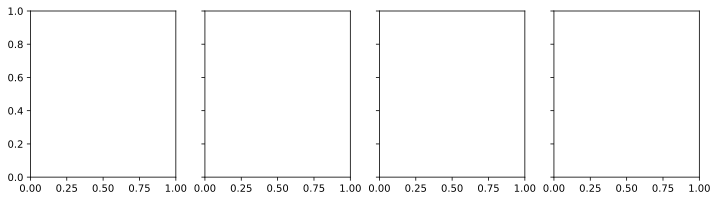

In [5]:
n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))


In [6]:

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')

x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

## Training Data

In [7]:
# This is the function that we use to generate data. We will try to get this function back from the generated data
def f(x):
    return 2 * torch.sin(x) * torch.tan(x/2) +  x


# We have training ad validation data
n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n) # Add some noise to the training labels
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

## Attention Pooling via Nadaraya-Watson Regression

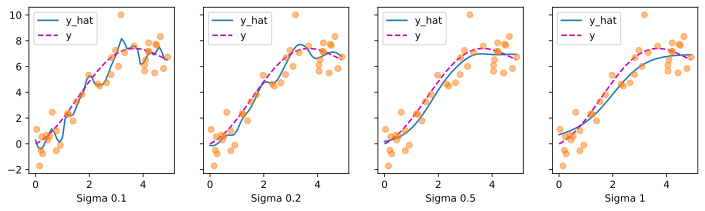

In [14]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    attention_w = k / k.sum(0)  # Normalization over keys for each query
    y_hat = y_train@attention_w
    return y_hat, attention_w

# x_train - key
# y_train - value
# x_val - query
# attention(q,k,v) = softmax(alpha(q,k)) * v
# alpha(q, k) - computes attention weights
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

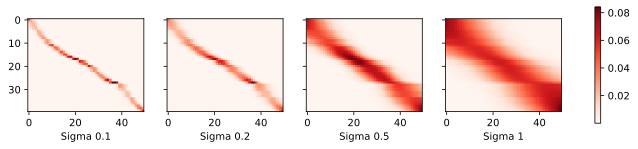

In [15]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

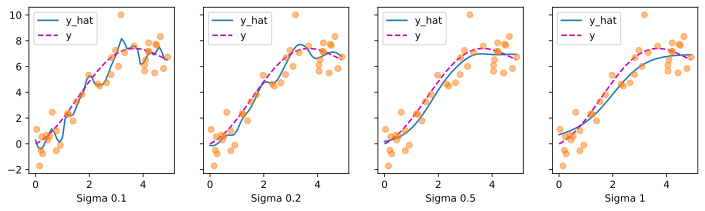

In [16]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]

plot(x_train, y_train, x_val, y_val, kernels, names)

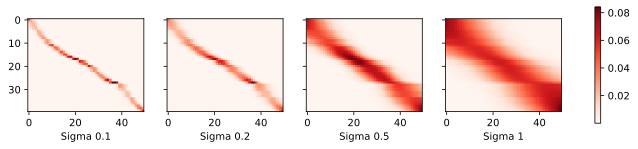

In [17]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

Why does the above work? Why do the kernels estimate but the constant kernel doesn't?

1. Note the kernel graphs - They have a high value at 0. That means when you pass a value close to 0 to these functions they return a high number as output.

2. The function we use - we find the difference between queries and keys. (For each query we find the diff with each key). This is essentially similarity in 1d (q and k both are numbers). In 2d we could use a different similarity function (euclidean, manhattan, etc.). Then we pass this similarity scores to the kernel - which gives higher values to most similar queries and keys (closer to 0)

3. Essentially we are are trying to map the query to the closest keys. Because in 1d if we have the key then we get the value. So higher attention is given to a certain key for a given query and then we get the value.


Also not that distance functinos are slightly more expensive to compute than inner products

## Masked Softmax Operation

In [18]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return torch.nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return torch.nn.functional.softmax(X.reshape(shape), dim=-1)

In [19]:
X = torch.rand(2 ,2 ,4)
valid_lens = torch.tensor([2, 3])
masked_softmax(X, valid_lens)

tensor([[[0.5088, 0.4912, 0.0000, 0.0000],
         [0.6415, 0.3585, 0.0000, 0.0000]],

        [[0.3599, 0.3413, 0.2987, 0.0000],
         [0.3531, 0.2701, 0.3769, 0.0000]]])

In [20]:
X.shape

torch.Size([2, 2, 4])

In [21]:
class DotProductAttention(torch.nn.Module):
    def __init__(self, dropout, num_heads = None) -> None:
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
        self.num_heads = num_heads

    def forward(self, queries: torch.tensor, keys: torch.tensor, values: torch.tensor, valid_lens = None, window_mask = None):
        d = queries.shape[-1]

        # queries are n (batch) * m * d
        # m is number of queries
        # Why is one query and key 2 d - like whis is m * d instead of 1 * d? each query is 1d only but each batch can have multiple (m) queries
        scores = torch.bmm(queries, keys.transpose(1, 2))/math.sqrt(d)

        if window_mask is not None:
            num_windows = window_mask.shape[0]
            n, num_queries, num_kv_pairs = scores.shape
            #Shape of window_mask: (num_windows, no. of queries,
            # no. of key-value pairs)
            scores = scores.reshape((n // (num_windows * self.num_heads), num_windows, self.
            num_heads, num_queries, num_kv_pairs)) + window_mask.unsqueeze(1).unsqueeze(0)
            scores = scores.reshape((n, num_queries, num_kv_pairs))

        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)
        

In [22]:
# batch size 2
# 10 k, v pairs
# vd = 4
# qd = kd = 2

queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
output = attention(queries, keys, values, valid_lens)
d2l.check_shape(output, (2, 1, 4))

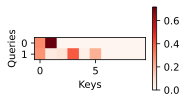

In [63]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [64]:
class AdditiveAttention(torch.nn.Module):
    def __init__(self, num_hiddens, dropout, **kwargs) -> None:
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = torch.nn.LazyLinear(num_hiddens, bias = False)
        self.W_q = torch.nn.LazyLinear(num_hiddens, bias = False)
        self.W_v = torch.nn.LazyLinear(1, bias = False)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        #There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [65]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

/home/mohitm/repos/transformers/env/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Multi-Head Attention

In [25]:
class MultiHeadAttention(d2l.Module):
    def __init__(self, num_hiddens, num_heads, dropout, bias = False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout, num_heads)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def transpose_qkv(self, X):
        """Transposition for parallel computation of multiple attention heads."""
        # Shape of input X: (batch_size, no. of queries or key-value pairs,
        # num_hiddens). Shape of output X: (batch_size, no. of queries or
        # key-value pairs, num_heads, num_hiddens / num_heads)
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        # Shape of output X: (batch_size, num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)
        X = X.permute(0, 2, 1, 3)
        # Shape of output: (batch_size * num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)
        return X.reshape(-1, X.shape[2], X.shape[3])


    def transpose_output(self, X):
        """Reverse the operation of transpose_qkv."""
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)

    def forward(self, queries, keys, values, valid_lens, window_mask = None):
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)

        output = self.attention(queries, keys, values, valid_lens, window_mask)

        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

In [26]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)

/home/mohitm/repos/transformers/env/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [28]:
batch_size, num_queries, num_kvpairs, valid_lens = 2, 4, 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
output = attention(X, Y, Y, valid_lens)
d2l.check_shape(output,
                (batch_size, num_queries, num_hiddens))

In [29]:
output.shape

torch.Size([2, 4, 100])

In [8]:
import torch
from d2l import torch as d2l

class PositionalEncoding(torch.nn.Module):
    def __init__(self, embed_dim, dropout=0, max_len=1000) -> None:
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)

        self.P = torch.empty((1, max_len, embed_dim))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(
            10000, torch.arange(0, embed_dim, 2, dtype=torch.float32) / embed_dim
        )

        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)


    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

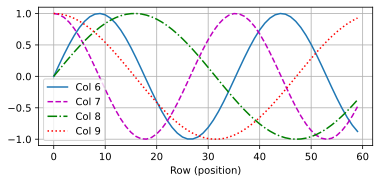

In [9]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

In the positional embedding matrix 
P
, rows correspond to positions within a sequence and columns represent different positional encoding dimensions. In the example below, we can see that the 
6
th
 and the 
7
th
 columns of the positional embedding matrix have a higher frequency than the 
8
th
 and the 
9
th
 columns. The offset between the 
6
th
 and the 
7
th
(same for the 
8
th
 and the 
9
th
) columns is due to the alternation of sine and cosine functions.

 the positional encoding decreases frequencies along the encoding dimension by using trigonometric functions.

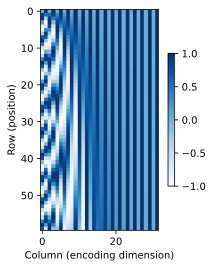

In [6]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

Lower frequency as the dimension increases